In [1]:
sc

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
16,application_1675528049135_0017,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-16>

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd

from pyspark.mllib.linalg.distributed import IndexedRowMatrix, IndexedRow

from pyspark.sql.functions import udf, struct
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import col
import pyspark.sql.functions as f



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
n_samples=1600
n_clusters=3
n_features =2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)
print(Xs.shape)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1600, 2)

In [36]:
cluster_centers_np = np.random.randn(n_clusters, n_features)
print(cluster_centers_np)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[ 0.38614874  0.17219811]
 [ 0.77807089  0.22668619]
 [-1.20179506  1.06801434]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

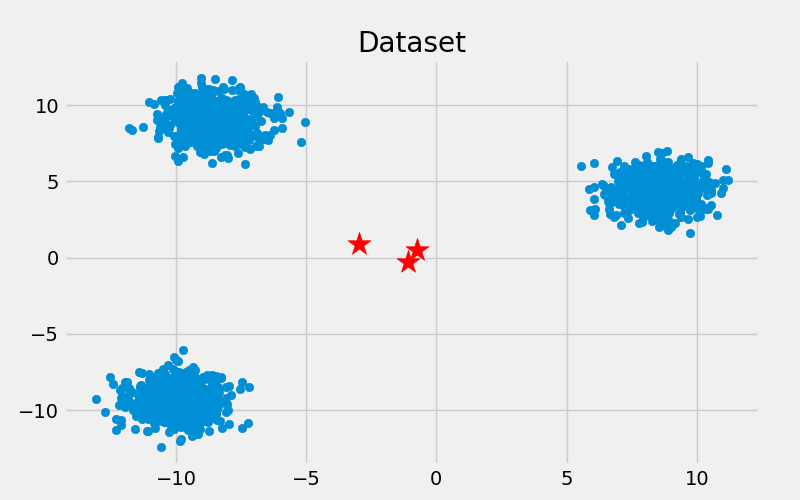

In [7]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

C= cluster_centers_np
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')

%matplot plt

In [8]:
x_df=spark.createDataFrame(pd.DataFrame(Xs,columns=list(['x1','x2'])))
x_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+
|                x1|                x2|
+------------------+------------------+
|  6.73023735866654| 5.930825399665926|
|  8.98853645131158|4.3714084029673534|
|-9.069312923209587|-8.245013649043477|
| 9.665007593614948|4.2238508821953396|
|-9.999697249385967|-8.564980919874639|
+------------------+------------------+
only showing top 5 rows

In [9]:
#row = np.array(df.collect()[1])
#print(np.linalg.norm(row-cluster_centers_np[0])**2)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def distance_from(mycenter):
    return f.udf(lambda myrow: sum([(x-mycenter[it])**2 for it,x in enumerate(myrow)]), FloatType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
x_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+
|                 x1|                 x2|
+-------------------+-------------------+
|   6.73023735866654|  5.930825399665926|
|   8.98853645131158| 4.3714084029673534|
| -9.069312923209587| -8.245013649043477|
|  9.665007593614948| 4.2238508821953396|
| -9.999697249385967| -8.564980919874639|
| -9.200335356750989|  7.302904831976651|
| -9.823413904079372|-10.603942214936811|
| -8.890131847691658|  8.816491904144613|
| -8.931665753649677| -9.296934346382645|
| -7.068429304095122|  9.688659011682235|
| -10.04286489476779|  9.519223622977496|
| -8.853007103103122| 10.303885315345534|
|   8.14306550042263|  5.127281957000719|
| -10.79209321473029| -11.16339336765941|
|  6.878850326204755|  3.866721436656245|
|-10.477756666110178| -9.748521081596827|
| -9.774408898357947|  8.341539776286655|
| -8.975458864817176| -7.841047426547503|
|  7.487265080938265| 3.8695815644741898|
| -9.374752454567975| -9.452902806844486|
+-------------------+-------------

In [12]:
results_df =x_df
for i in np.arange(n_clusters):
    act_center=list(float(it) for it in cluster_centers_np[i])
    results_df = results_df.withColumn(f"sq_norm_{i}", distance_from(act_center)(struct([x_df[x] for x in x_df.columns])))
results_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+---------+----------+----------+
|                 x1|                 x2|sq_norm_0| sq_norm_1| sq_norm_2|
+-------------------+-------------------+---------+----------+----------+
|   6.73023735866654|  5.930825399665926| 85.16578|  119.4315|100.094284|
|   8.98853645131158| 4.3714084029673534|109.54428| 154.98564| 123.58953|
| -9.069312923209587| -8.245013649043477|146.07202| 120.58474| 126.69581|
|  9.665007593614948| 4.2238508821953396| 122.0482| 170.60239|  136.3446|
| -9.999697249385967| -8.564980919874639|168.14227| 138.75804| 147.57677|
| -9.200335356750989|  7.302904831976651|117.66451|  80.17001| 123.28509|
| -9.823413904079372|-10.603942214936811|206.08656| 178.98355| 182.35802|
| -8.890131847691658|  8.816491904144613|135.35681|  98.12777| 143.64442|
| -8.931665753649677| -9.296934346382645|163.33066| 139.22769| 142.35638|
| -7.068429304095122|  9.688659011682235| 124.2282|  94.44892| 135.24092|
| -10.04286489476779|  9.5192236229774

In [13]:
sq_norms_df=results_df.select([f"sq_norm_{i}" for i in np.arange(n_clusters)])
sq_norms_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------+----------+
|sq_norm_0| sq_norm_1| sq_norm_2|
+---------+----------+----------+
| 85.16578|  119.4315|100.094284|
|109.54428| 154.98564| 123.58953|
|146.07202| 120.58474| 126.69581|
| 122.0482| 170.60239|  136.3446|
|168.14227| 138.75804| 147.57677|
|117.66451|  80.17001| 123.28509|
|206.08656| 178.98355| 182.35802|
|135.35681|  98.12777| 143.64442|
|163.33066| 139.22769| 142.35638|
| 124.2282|  94.44892| 135.24092|
|167.63753|124.772484| 176.22546|
|161.66588|123.508705| 172.38072|
| 100.2114| 141.34236| 114.86499|
|237.37332| 206.37926|  212.0413|
|   69.304| 105.74655|  81.00889|
|200.11311| 169.47539| 177.29181|
|142.88968| 102.08234| 149.77122|
|137.60461|112.237305|118.948204|
|78.965096| 118.10767| 91.114655|
|173.87004| 147.91383|  152.3236|
+---------+----------+----------+
only showing top 20 rows

In [14]:
@udf(returnType=IntegerType()) 
def min_dist(myrow):
    dist=int(np.argmin(np.array([x for x in myrow])))
    return dist

results_df = results_df.withColumn("min_dist", min_dist(struct([sq_norms_df[x] for x in sq_norms_df.columns])))
results_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+---------+----------+----------+--------+
|                 x1|                 x2|sq_norm_0| sq_norm_1| sq_norm_2|min_dist|
+-------------------+-------------------+---------+----------+----------+--------+
|   6.73023735866654|  5.930825399665926| 85.16578|  119.4315|100.094284|       0|
|   8.98853645131158| 4.3714084029673534|109.54428| 154.98564| 123.58953|       0|
| -9.069312923209587| -8.245013649043477|146.07202| 120.58474| 126.69581|       1|
|  9.665007593614948| 4.2238508821953396| 122.0482| 170.60239|  136.3446|       0|
| -9.999697249385967| -8.564980919874639|168.14227| 138.75804| 147.57677|       1|
| -9.200335356750989|  7.302904831976651|117.66451|  80.17001| 123.28509|       1|
| -9.823413904079372|-10.603942214936811|206.08656| 178.98355| 182.35802|       1|
| -8.890131847691658|  8.816491904144613|135.35681|  98.12777| 143.64442|       1|
| -8.931665753649677| -9.296934346382645|163.33066| 139.22769| 142.35638|       1|
| -7

In [15]:
column_names = [f'x{i}' for i in np.arange(1,n_features+1)]
#print(column_names)

selected_rows_df=results_df.filter(results_df.min_dist == 0).select(column_names)
selected_rows_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+
|                x1|                x2|
+------------------+------------------+
|  6.73023735866654| 5.930825399665926|
|  8.98853645131158|4.3714084029673534|
| 9.665007593614948|4.2238508821953396|
|  8.14306550042263| 5.127281957000719|
| 6.878850326204755| 3.866721436656245|
| 7.487265080938265|3.8695815644741898|
| 8.532038937735294| 4.377720091662975|
| 9.209451016236564| 5.102109418976008|
|10.012228783284534|6.1204336919016304|
|  7.14894528820804| 5.191528544495565|
| 7.575626860333687|4.2452476299046715|
| 8.829069944851623|  5.45237304328226|
|10.361829601014804|  4.47749672070945|
| 7.113966070861037| 4.126868865964766|
| 7.520682839267314| 4.062760209273119|
| 8.516316424117658| 6.027246189885087|
| 8.619978524361674| 5.536163885330674|
| 6.567638006047394|4.3234477293878975|
| 8.752159274213136| 3.474526184184466|
| 7.236888569824117| 4.937154207357682|
+------------------+------------------+
only showing top 20 rows

In [16]:
from pyspark.sql.functions import mean

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
selected_rows_df.select([mean('x1'),mean('x2')]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+------------------+
|          avg(x1)|           avg(x2)|
+-----------------+------------------+
|8.568279944090753|4.4605123252462535|
+-----------------+------------------+

In [18]:
mylist = [ mean(it) for it in column_names]
mylist

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Column<b'avg(x1)'>, Column<b'avg(x2)'>]

In [19]:
np.squeeze(np.array(selected_rows_df.select(mylist).collect()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([8.56827994, 4.46051233])

## Everything Together In a Loop

In [86]:
cluster_centers_np = np.random.randn(n_clusters, n_features)
print(cluster_centers_np)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[-0.95323037  0.56966289]
 [-0.64082557  0.8100393 ]
 [-0.22498996 -0.8651519 ]]

In [87]:
x_column_names = [f'x{i}' for i in np.arange(1,n_features+1)]
x_column_mean_list = [ mean(it) for it in column_names]
cluster_centers_hist = []
cluster_centers_hist.append(cluster_centers_np)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

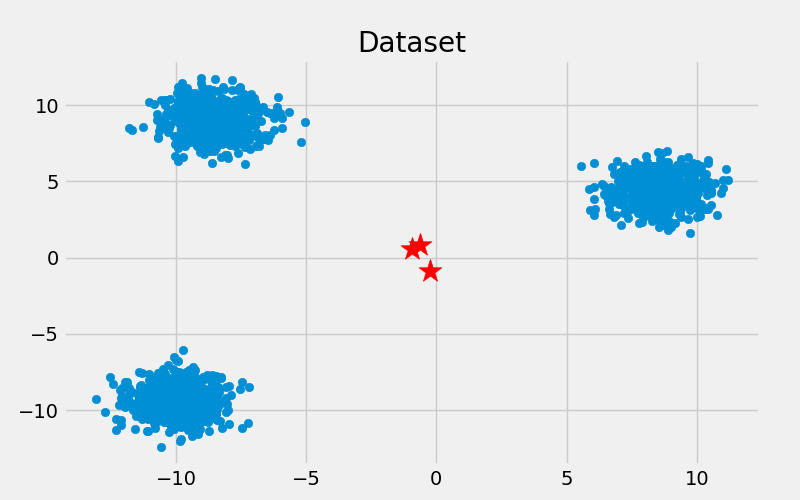

In [88]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

C= cluster_centers_hist[-1]
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')
%matplot plt

In [89]:
em_iter_num = 5

for emiter in np.arange(em_iter_num):
    #print(cluster_centers_np)
    results_df =x_df

    for i in np.arange(n_clusters):
        act_center=list(float(it) for it in cluster_centers_np[i])
        results_df = results_df.withColumn(f"sq_norm_{i}", distance_from(act_center)(struct([x_df[x] for x in x_df.columns])))
    #results_df.show()

    sq_norms_df=results_df.select([f"sq_norm_{i}" for i in np.arange(n_clusters)])
    #sq_norms_df.show()

    results_df = results_df.withColumn("min_dist", min_dist(struct([sq_norms_df[x] for x in sq_norms_df.columns])))
    #results_df.show()


    new_means=[]
    for it in range(n_clusters):
        selected_rows_df=results_df.filter(results_df.min_dist == it).select(x_column_names)
        #selecte=[]d_rows_df.show()
        new_means.append(np.squeeze(np.array(selected_rows_df.select(x_column_mean_list).collect())))
        
        #print(new_means)

    for it in range(n_clusters):
        try:
            _ = np.sum(new_means[it])
            cluster_centers_np[it] = new_means[it]
        except:
            pass

    cluster_centers_hist.append(cluster_centers_np)
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

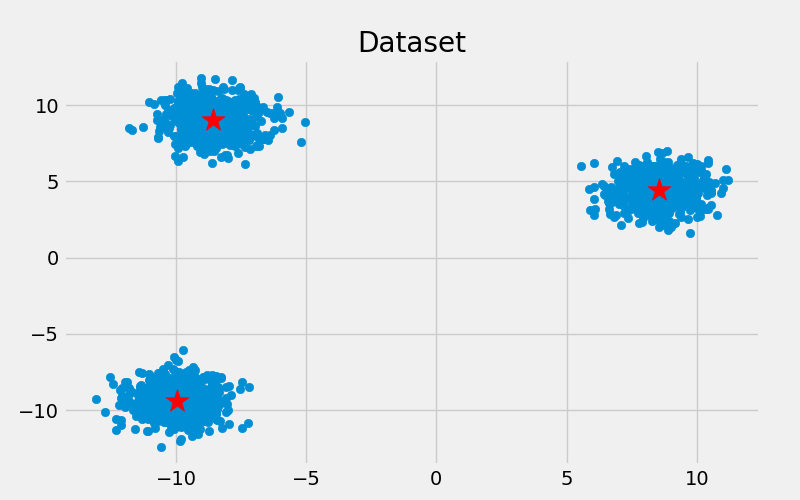

In [90]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

C= cluster_centers_hist[-1]
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')
%matplot plt